In [1]:
import torch 
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
torch.__version__

"""
Linronald 201901
"""

'1.3.1'

## super params

In [126]:
EPOCHS = 10 # 总共训练批次
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 让torch判断是否使用GPU
LEARNING_RATE = 0.001
type_mapping = {'bipolar':0,'tanh':1,
                'gaussian':2,'sinusoidal':3,
                'linear':4,'dip':5}

## class: my own dataset

In [71]:
class SignalDataset(Dataset):
    # torch要求的数据输入，使用封装好的loader。
    def __init__(self, json_file):
        self.df=pd.read_json(json_file)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        data = np.array(pd.Series(self.df.loc[idx]['data']),dtype=np.float64)
        data = data.reshape(1,100)
        return self.df.loc[idx]['type'],torch.from_numpy(data)

## class my network

In [4]:
class ConvNet(nn.Module):
    # 卷积神经网络的主体，在这里定义
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1,out_channels=5,kernel_size=10,stride=5) # 定义卷积运算1
        self.conv2 = nn.Conv1d(5,out_channels=10,kernel_size=5) # 定义卷积运算2
        self.fc1 = nn.Linear(10*15,50) # 定义全连接层1
        self.fc2 = nn.Linear(50,10) # 定义全连接层2
        self.fc3 = nn.Linear(10,6) # 定义全连接层3
    def forward(self,x): # 神经网络的前向传播
        batch_size = x.size(0)
        out = self.conv1(x) # batch(=5)*1*100 -> batch*5*19
        out = F.relu(out) # batch*5*19
        out = self.conv2(out) # batch*5*19 -> batch*10*15
        out = F.relu(out) # batch*10*15
        out = out.view(batch_size, -1) # batch*10*15 -> batch*150
        out = self.fc1(out) # batch*150 -> batch*50
        out = F.relu(out) # batch*50
        out = self.fc2(out) # batch*50 -> batch*2
        out = F.relu(out) # 使用ReLU作为激活函数
        out = self.fc3(out)
        out = torch.sigmoid(out) 
        return out

## load data and train

In [221]:
ds_train = SignalDataset('final_train_set.json')
BATCH_SIZE = 10
'case0:',ds_train[0][0],len(ds_train[0][1]),type(ds_train[0][1]),ds_train[0][1].dtype
dl_train = torch.utils.data.DataLoader(ds_train, BATCH_SIZE, shuffle=True, num_workers=0)
len(ds_train)
LOSSLIST = list()
CORRECTLIST = list()

('case0:', 'gaussian', 1, torch.Tensor, torch.float64)

1036

In [216]:
# initialize model
model = ConvNet().to(DEVICE)
model = model.double()

dl_test_on_train_set = torch.utils.data.DataLoader(ds_train,1,shuffle=True,num_workers=0)
correct = test_on_trainset(model, DEVICE, dl_test_on_train_set)
# 这边这个test_on_trainset()是在下面定义的，先运行下面一个block就好。
'correct:',correct,correct/ len(dl_test_on_train_set)
# 展示初始模型（参数随机设置）的正确率。

('correct:', 151, 0.14575289575289574)

## my functions

In [122]:
# 定义函数的跑一遍就好，然后可以点击my functions左边的小箭头，把这个隐藏起来。
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_index, (target_str, data) in enumerate(train_loader):
#         target_str, data = target_str.to(device), data.to(device)
#         emm反正我也不用GPU
        target = [type_mapping[mystr] for mystr in target_str]
        target = torch.tensor(target,dtype=torch.long)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
#         print(output,target)
        LOSSLIST.append(loss)
        loss.backward()
        optimizer.step()

def test_on_trainset(_model, device, test_loader):
    # 输入是模型，数据loader
    _model.eval()
    correct = 0
    with torch.no_grad():
        for target_strs, data in test_loader:
            output = _model(data)
            output_res = output.argmax().item()
            target = type_mapping[target_strs[0]]
            if output_res == target:
#                 print(target,output_res)
                correct+= 1
            else:
                pass
    return correct

## some other things

correct: 1005 0.9700772200772201
correct: 1012 0.9768339768339769
correct: 1008 0.972972972972973
correct: 1008 0.972972972972973
correct: 1008 0.972972972972973
correct: 1005 0.9700772200772201
correct: 1016 0.9806949806949807
correct: 1012 0.9768339768339769
correct: 1021 0.9855212355212355
correct: 1023 0.9874517374517374


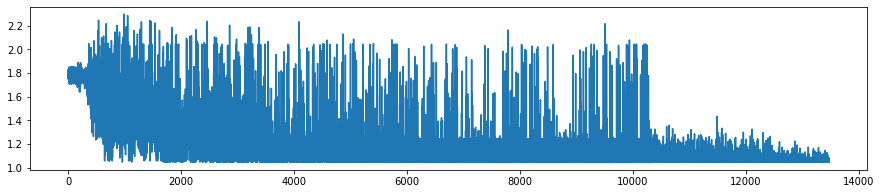

In [222]:
# train
OPTIMIZER = optim.Adam(model.parameters(),lr=LEARNING_RATE)

# dl_test = torch.utils.data.DataLoader(ds, 1, shuffle=True,num_workers=0)
# test_correct = test_on_trainset(model, DEVICE, dl_test)
# print('epoch 0 : with %d correct recognition on the train set, namely %.2f %%'%(test_correct,100.*(test_correct/len(dl_test))))
for epoch in range(1, EPOCHS+1):
    train(model,DEVICE,dl_train,OPTIMIZER,epoch)
#     if epoch%5==0:
#         print(epoch)
#     test_correct = test_on_trainset(model, DEVICE, dl_test)
#     print('epoch %d : with %d correct recognition on the train set, namely %.2f %%'%(epoch,test_correct,100.*((test_correct/len(dl_test)))))
    correct = test_on_trainset(model, DEVICE, dl_test_on_train_set)
    print('correct:',correct,correct/ len(dl_test_on_train_set))
    # 每次训练输出正确判断的数量和比例，然后加到CORRECTLIST里面来，画图。
    CORRECTLIST.append(correct)
    
fig = plt.figure(figsize=(15,3))
plt.plot(LOSSLIST)

## test on th test set

In [136]:
ds_test = SignalDataset('final_test_set.json')
'case0:',ds_test[0][0],len(ds_test[0][1]),type(ds_test[0][1]),ds_test[0][1].dtype
# 打印出来第一行数据，检查一下。如果不要这行可以删掉。
dl_test_on_test_set = torch.utils.data.DataLoader(ds_test, 1, shuffle=True, num_workers=0)
correct = test_on_trainset(model, DEVICE, dl_test_on_test_set)
'correct:',correct,correct/ len(dl_test_on_test_set)
# 这边展示在测试集上的正确率

('case0:', 'tanh', 1, torch.Tensor, torch.float64)

('correct:', 292, 0.9733333333333334)

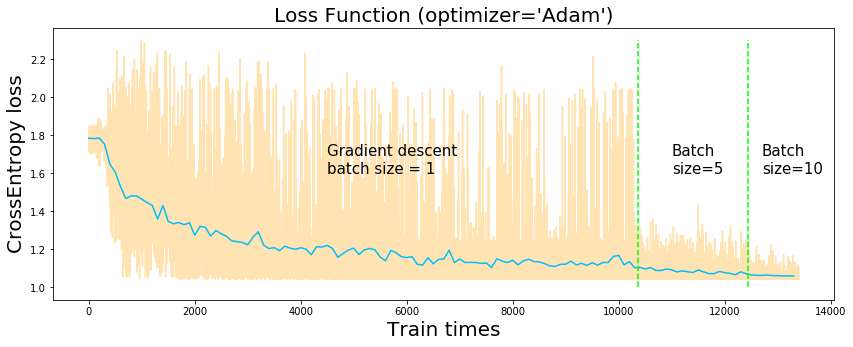

In [254]:
# 接下来都是画图了
fig = plt.figure(figsize=(14,5))
_=plt.plot(LOSSLIST[:13400],alpha=0.3,color='orange')
_=plt.plot(100*np.arange(loss.shape[0]),loss,color='deepskyblue')
_=plt.xlabel('Train times',fontsize=20)
_=plt.ylabel('CrossEntropy loss',fontsize=20)
_=plt.title("Loss Function (optimizer='Adam')",fontsize=20)
_=plt.plot((10360,10360),(1.0,2.3),'--',color='lime')
_=plt.plot((12432,12432),(1.0,2.3),'--',color='lime')
_=plt.text(4500,1.6,'Gradient descent\nbatch size = 1',fontsize=15)
_=plt.text(11000,1.6,'Batch\nsize=5',fontsize=15)
_=plt.text(12700,1.6,'Batch\nsize=10',fontsize=15)

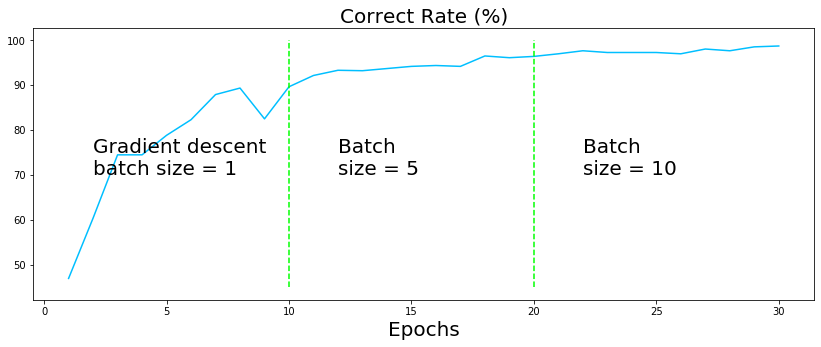

In [253]:
fig = plt.figure(figsize=(14,5))
_=plt.plot(range(1,len(CORRECTLIST)+1),np.array(CORRECTLIST)/1036*100,color='deepskyblue')
_=plt.xlabel('Epochs',fontsize=20)
_=plt.plot((10,10),(45,100),'--',color='lime')
_=plt.plot((20,20),(45,100),'--',color='lime')
_=plt.text(2,70,'Gradient descent\nbatch size = 1',fontsize=20)
_=plt.text(12,70,'Batch\nsize = 5',fontsize=20)
_=plt.text(22,70,'Batch\nsize = 10',fontsize=20)
_=plt.title('Correct Rate (%)',fontsize=20)